In [1]:
#import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.tsaplots import plot_acf
import os
import scipy.optimize as optimize
import scipy.stats as stats
from scipy.stats import laplace_asymmetric

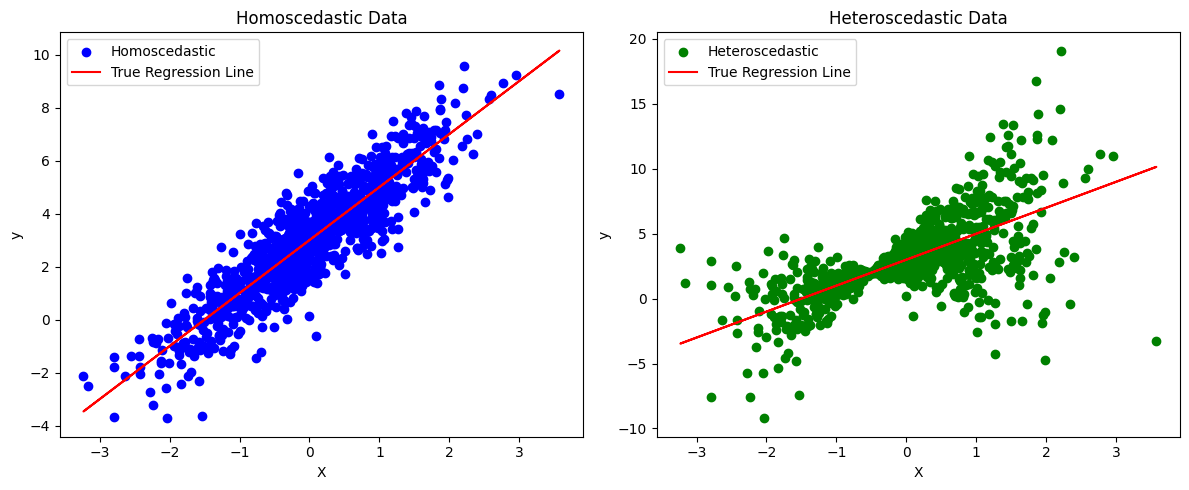

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)  # Setting a seed for reproducibility

# Simulating homoscedastic data
n = 1000
X = np.random.normal(0, 1, size=(n, 1))
eps = np.random.normal(0, 1, size=(n, 1))
y_homoscedastic = 2 * X + 3 + eps

# Simulating heteroscedastic data
hetero_var = np.abs(2 * X + 1)  # Varying variance based on X
y_heteroscedastic = 2 * X + 3 + hetero_var * eps

# Plotting the data
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X, y_homoscedastic, color='b', label='Homoscedastic')
plt.plot(X, 2 * X + 3, color='r', label='True Regression Line')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Homoscedastic Data')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X, y_heteroscedastic, color='g', label='Heteroscedastic')
plt.plot(X, 2 * X + 3, color='r', label='True Regression Line')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Heteroscedastic Data')
plt.legend()

plt.tight_layout()
plt.show()


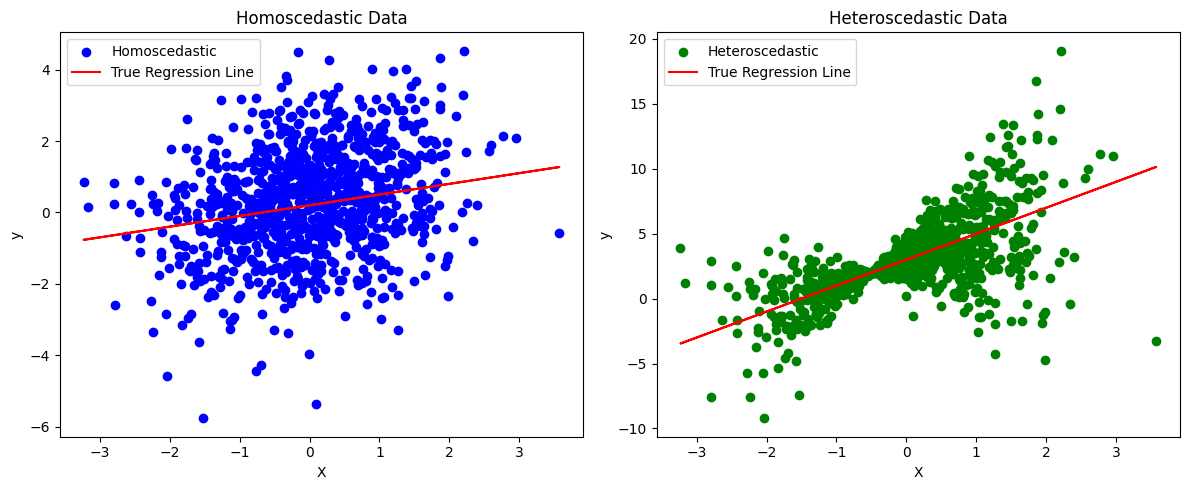

In [6]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(123)  # Setting a seed for reproducibility

# Simulating homoscedastic data
n = 1000
X = np.random.normal(0, 1, size=(n, 1))
eps = np.random.normal(0, 1, size=(n, 1))
y_homoscedastic = 0.2 + y_homoscedastic * 0.5 +  0.3 * X  + eps

# Simulating heteroscedastic data
hetero_var = np.abs(2 * X + 1)  # Varying variance based on X
y_heteroscedastic = 2 * X + 3 + hetero_var * eps

# Plotting the data
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X, y_homoscedastic, color='b', label='Homoscedastic')
plt.plot(X,  0.2 + 0.3 * X  , color='r', label='True Regression Line')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Homoscedastic Data')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X, y_heteroscedastic, color='g', label='Heteroscedastic')
plt.plot(X, 2 * X + 3, color='r', label='True Regression Line')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Heteroscedastic Data')
plt.legend()

plt.tight_layout()
plt.show()


In [2]:
''' Data Generation '''
################################'Generate X and Y'##############################
################################ Xt ~ N(0,1)
################################ Yt = α + βYt-1 + γXt + εt + θεt-1
def generate_data(T, alpha_y, beta_y, gamma, theta, sigma_y, mu, seed=None):
    np.random.seed(seed)
    df = pd.DataFrame(index=range(T), columns=['x', 'y', 'epsilon_y'])
    x = np.random.normal(0, 1, T)
    y1 = np.random.normal(mu, sigma_y)
    epsilon_y = sigma_y*np.random.randn(T)
    df.iloc[0,:] = [x[0], y1, epsilon_y[0]]
    
    for i in range(0, T-1):
        df.iloc[i+1,0] = x[i+1] 
        # Xt ~ N(0,1)
        df.iloc[i+1,1] = alpha_y + beta_y * df.iloc[i,1] + gamma * df.iloc[i+1,0] + epsilon_y[i+1] + theta * epsilon_y[i] # generate Y(t) recursively
        # Yt = α + βYt-1 + γXt + εt + θεt-1
        df.iloc[i+1,2] = epsilon_y[i+1]
    
    return df


In [3]:
df = generate_data(1000, 0.2, 0.5, 0.3, 0.9, 1, 0, seed=42)
print(df)

            x         y epsilon_y
0    0.496714  1.399355  0.924634
1   -0.138264  1.749999   0.05963
2    0.647689  0.676037 -0.646937
3     1.52303  1.110908  0.698223
4   -0.234153  1.707094  0.393485
..        ...       ...       ...
995   -0.2811  2.353144 -0.026521
996  1.797687  1.010134 -0.881875
997  0.640843 -0.059434 -0.163067
998 -0.571179 -0.892734 -0.744903
999  0.572583 -1.420183 -0.675178

[1000 rows x 3 columns]


In [6]:
def ols_gls_estimationM(df, M, initial_params):
    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['y'].values
    T = min(M, len(y_dataset))
    y = df['y'].values[:T]
    x = df['x'].values[:T]  # extract data
    epsilon_y = df['epsilon_y'].values[:T]

    ols_alpha_hat = []
    ols_beta_hat = []
    ols_gamma_hat = []
    ols_theta_hat = []
    gls_alpha_hat = []
    gls_beta_hat = []
    gls_gamma_hat = []
    gls_theta_hat = []

    np.random.seed(123)
    for i in range(M):
        #epsilon = np.random.normal(T)  # Generate new errors for each iteration
        epsilon = np.random.randn(T) # Generate new errors for each iteration

        y = y + epsilon  # Update y with new errors

        # OLS estimation of the parameters
        y_lag = np.roll(y, 1)
        y_lag[0] = 0
        epsilon_lag = np.roll(epsilon_y, 1)
        epsilon_lag[0] = 0
        X = np.column_stack((np.ones_like(x), y_lag, x))
        beta_hat = np.linalg.inv(X.T @ X) @ X.T @ y
    
        ε = y - X @ beta_hat
        ε = ε.reshape((-1, 1))
        ε_lag = np.roll(ε, 1)
        ε_lag[0] = 0
        ε_lag = ε_lag.reshape((-1, 1))
        theta_hat = np.linalg.inv(ε.T @ ε_lag) @ ε_lag.T @ ε
        beta_hat = np.concatenate((beta_hat, [theta_hat[0, 0]]))

        acf_resid, ci = sm.tsa.stattools.acf(ε, nlags=50, alpha=0.05)
        sigma2 = np.var(ε) * (1 - acf_resid[1])
        sigma2_array = np.full(T, sigma2)
        rho = acf_resid[1] / (1 - acf_resid[1])
        S = np.diag(sigma2_array) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=1) + rho * np.diag(np.sqrt(sigma2_array[:-1] * sigma2_array[1:]), k=-1)
        beta_gls = np.linalg.inv(X.T @ np.linalg.inv(S) @ X) @ X.T @ np.linalg.inv(S) @ y
        theta_gls = np.linalg.inv(ε.T @ np.linalg.inv(S) @ ε_lag) @ ε_lag.T @ np.linalg.inv(S) @ ε
        beta_gls = np.concatenate((beta_gls, [theta_gls[0, 0]]))

        # Store parameter estimates
        ols_alpha_hat.append(beta_hat[0])
        ols_beta_hat.append(beta_hat[1])
        ols_gamma_hat.append(beta_hat[2])
        ols_theta_hat.append(theta_hat[0, 0])
        gls_alpha_hat.append(beta_gls[0])
        gls_beta_hat.append(beta_gls[1])
        gls_gamma_hat.append(beta_gls[2])
        gls_theta_hat.append(theta_gls[0, 0])

        # Check convergence to initial parameters
        if np.allclose([ols_alpha_hat[-1], ols_beta_hat[-1], ols_gamma_hat[-1], ols_theta_hat[-1], gls_alpha_hat[-1], gls_beta_hat[-1], gls_gamma_hat[-1], gls_theta_hat[-1]], initial_params):
            print("Converged after {} iterations".format(_+1))
        break

    # Print or perform further analysis using the stored parameter estimates
    print("Parameter estimates:")
    print("OLS alpha_hat: ", ols_alpha_hat)
    print("OLS beta_hat: ", ols_beta_hat)
    print("OLS gamma_hat: ", ols_gamma_hat)
    print("OLS theta_hat: ", ols_theta_hat)
    print("GLS alpha_hat: ", gls_alpha_hat)
    print("GLS beta_hat: ", gls_beta_hat)
    print("GLS gamma_hat: ", gls_gamma_hat)
    print("GLS theta_hat: ", gls_theta_hat)


    actuals = np.array([0.2, 0.5, 0.3, 0.9])  # True parameters alpha, beta, gamma, theta
  # Calculate the biases
    biases_ols = actuals - np.array(beta_hat)
    for i, bias in enumerate(biases_ols):
        print(f"OLS_bias_param_{i} = {bias:.4f}")
    
    mse_ols = np.mean(np.square(biases_ols)) # Calculate RMSE
    rmse_ols = np.sqrt(mse_ols)
    print(f"OLS_RMSE = {rmse_ols:.4f}")
    
    biases_gls = actuals - np.array(beta_gls) # Calculate the biases
    for i, bias in enumerate(biases_gls):
        print(f"GLS_bias_param_{i} = {bias:.4f}")
    
    mse_gls = np.mean(np.square(biases_gls)) # Calculate RMSE
    rmse_gls = np.sqrt(mse_gls)
    print(f"GLS_RMSE = {rmse_gls:.4f}")


In [7]:
M=100
initial_params = 0.2, 0.5, 0.3, 0.9, 0.2, 0.5, 0.3, 0.9
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [0.4559455463060822]
OLS beta_hat:  [0.5036939727015716]
OLS gamma_hat:  [-0.09799500195764527]
OLS theta_hat:  [1.0000000000000016]
GLS alpha_hat:  [0.4476169421122218]
GLS beta_hat:  [0.5131011572666253]
GLS gamma_hat:  [-0.09529768894656782]
GLS theta_hat:  [1.0000000000125056]
OLS_bias_param_0 = -0.2559
OLS_bias_param_1 = -0.0037
OLS_bias_param_2 = 0.3980
OLS_bias_param_3 = -0.1000
OLS_RMSE = 0.2418
GLS_bias_param_0 = -0.2476
GLS_bias_param_1 = -0.0131
GLS_bias_param_2 = 0.3953
GLS_bias_param_3 = -0.1000
GLS_RMSE = 0.2386


In [8]:
M=250
initial_params = 0.2, 0.5, 0.3, 0.9, 0.2, 0.5, 0.3, 0.9
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [0.3078446775801853]
OLS beta_hat:  [0.6066843510027283]
OLS gamma_hat:  [0.09114797784357687]
OLS theta_hat:  [0.9999999999999981]
GLS alpha_hat:  [0.3056528208307938]
GLS beta_hat:  [0.6094446914631406]
GLS gamma_hat:  [0.09158865622634693]
GLS theta_hat:  [0.9999999999998357]
OLS_bias_param_0 = -0.1078
OLS_bias_param_1 = -0.1067
OLS_bias_param_2 = 0.2089
OLS_bias_param_3 = -0.1000
OLS_RMSE = 0.1384
GLS_bias_param_0 = -0.1057
GLS_bias_param_1 = -0.1094
GLS_bias_param_2 = 0.2084
GLS_bias_param_3 = -0.1000
GLS_RMSE = 0.1384


In [9]:
M=1000
initial_params = 0.2, 0.5, 0.3, 0.9, 0.2, 0.5, 0.3, 0.9
ols_gls_estimationM(df, M, initial_params)

Parameter estimates:
OLS alpha_hat:  [0.25447061320741066]
OLS beta_hat:  [0.5900422629395783]
OLS gamma_hat:  [0.2512666211612553]
OLS theta_hat:  [0.9999999999999994]
GLS alpha_hat:  [0.27438451057842206]
GLS beta_hat:  [0.5585761912495335]
GLS gamma_hat:  [0.25306784029104556]
GLS theta_hat:  [1.000000000000221]
OLS_bias_param_0 = -0.0545
OLS_bias_param_1 = -0.0900
OLS_bias_param_2 = 0.0487
OLS_bias_param_3 = -0.1000
OLS_RMSE = 0.0766
GLS_bias_param_0 = -0.0744
GLS_bias_param_1 = -0.0586
GLS_bias_param_2 = 0.0469
GLS_bias_param_3 = -0.1000
GLS_RMSE = 0.0727


In [11]:
def simulate_data(T, alpha, beta, gamma, theta):
    np.random.seed(123)
    X = np.zeros(T)
    Y = np.zeros(T)

    # Generate X values from N(0, 1)
    X[0] = np.random.normal(0, 1)

    epsilon_t = np.random.randn()
    epsilon_t_lag = np.roll(epsilon_t, 1)
    # Generate Y values
    for t in range(1, T):
        #epsilon_t = np.random.randn()
        #epsilon_t_lag = np.roll(epsilon_t, 1)
        X[t] = np.random.normal(0, 1)
        Y[t] = alpha + beta * Y[t - 1] + gamma * X[t] + epsilon_t + theta * epsilon_t_lag

    return pd.DataFrame({'X': X, 'Y': Y})

# Set the parameters for each quantile level
quantiles = [0.1, 0.5, 0.9]
parameters = {
    0.1: {'alpha': -1.2, 'beta': 0.3, 'gamma': 0.2, 'theta': 0.9},
    0.5: {'alpha': 0.2, 'beta': 0.5, 'gamma': 0.3, 'theta': 0.9},
    0.9: {'alpha': 1.2, 'beta': 0.7, 'gamma': 0.4, 'theta': 0.9}}
    
T = 334

df = pd.DataFrame()

# Simulate data for each quantile level and concatenate into a single DataFrame
for quantile in quantiles:
    params = parameters[quantile]
    data = simulate_data(T, params['alpha'], params['beta'], params['gamma'], params['theta'])
    df = pd.concat([df, data], ignore_index=True)
print(df)


             X          Y
0    -1.085631   0.000000
1     0.282978   0.751552
2    -1.506295   0.619163
3    -0.578600   0.764985
4     1.651437   1.254739
...        ...        ...
997  -0.145364  10.045232
998   1.868726  10.874109
999  -0.518704  10.499351
1000 -0.062399  10.419543
1001 -0.102911  10.347472

[1002 rows x 2 columns]


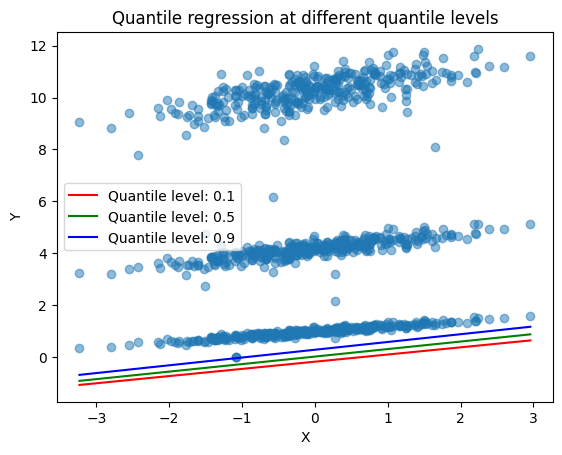

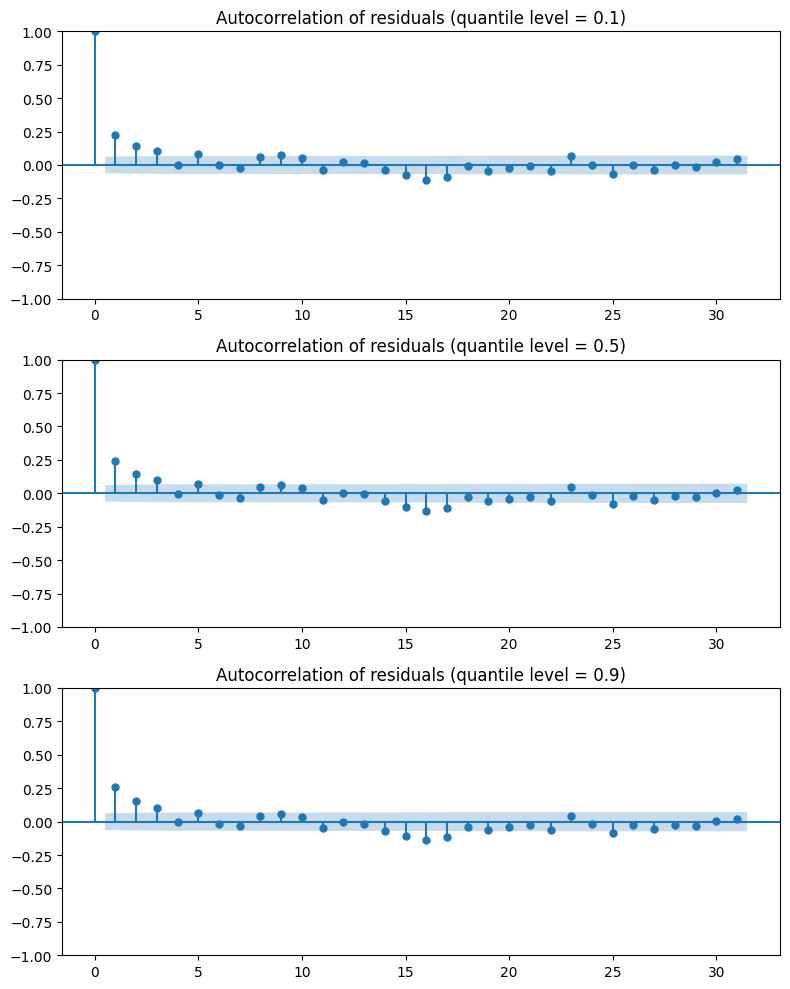

(<class 'statsmodels.iolib.summary.Summary'>
 """
                          QuantReg Regression Results                          
 Dep. Variable:                      y   Pseudo R-squared:               0.9164
 Model:                       QuantReg   Bandwidth:                     0.07845
 Method:                 Least Squares   Sparsity:                       0.9561
 Date:                Sat, 01 Jul 2023   No. Observations:                 1002
 Time:                        16:22:49   Df Residuals:                      999
                                         Df Model:                            2
                  coef    std err          t      P>|t|      [0.025      0.975]
 ------------------------------------------------------------------------------
 const         -0.1769      0.016    -11.405      0.000      -0.207      -0.146
 x1             0.9904      0.002    407.229      0.000       0.986       0.995
 x2             0.2769      0.010     26.761      0.000       0.257   

In [12]:
################################ Quantile linear regression with package ################################
def fit_quantile(df):
    y = df['Y'].values.astype(float)
    x = df['X'].values.astype(float)
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    
    X = np.column_stack((np.ones_like(x), y_lag, x))

    quant_reg_1 = sm.QuantReg(y, X).fit(q=0.1)
    quant_reg_5 = sm.QuantReg(y, X).fit(q=0.5)
    quant_reg_9 = sm.QuantReg(y, X).fit(q=0.9)

    # Plot the scatter data and the quantile regression lines
    fig, ax = plt.subplots()
    ax.scatter(x, y, alpha=0.5)

    # Generate x values for the regression lines
    x_vals = np.linspace(np.min(x), np.max(x), 250)

    # Plot the regression lines
    ax.plot(x_vals, quant_reg_1.params[0] + quant_reg_1.params[1]*0 + quant_reg_1.params[2]*x_vals, 'r', label='Quantile level: 0.1')
    ax.plot(x_vals, quant_reg_5.params[0] + quant_reg_5.params[1]*0 + quant_reg_5.params[2]*x_vals, 'g', label='Quantile level: 0.5')
    ax.plot(x_vals, quant_reg_9.params[0] + quant_reg_9.params[1]*0 + quant_reg_9.params[2]*x_vals, 'b', label='Quantile level: 0.9')

    # Add a legend and labels to the plot
    ax.legend()
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Quantile regression at different quantile levels')

    plt.show()

################################ Autocorrelation of the residuals ##############################
    residuals_1 = quant_reg_1.resid # Calculate the residuals
    residuals_5 = quant_reg_5.resid # Calculate the residuals
    residuals_9 = quant_reg_9.resid # Calculate the residuals

    # Plot the autocorrelation function of the residuals for all three quantile regression models in one plot
    fig, ax = plt.subplots(3, 1, figsize=(8, 10))
    plot_acf(quant_reg_1.resid, ax=ax[0])
    ax[0].set_title('Autocorrelation of residuals (quantile level = 0.1)')
    plot_acf(quant_reg_5.resid, ax=ax[1])
    ax[1].set_title('Autocorrelation of residuals (quantile level = 0.5)')
    plot_acf(quant_reg_9.resid, ax=ax[2])
    ax[2].set_title('Autocorrelation of residuals (quantile level = 0.9)')
    plt.tight_layout()
    plt.show()

    return quant_reg_1.summary(), quant_reg_5.summary(), quant_reg_9.summary()

fit_quantile(df)

In [15]:
def Laplace_estimation(df, p, M):

    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['y'].values
    T = min(M, len(y_dataset))
    y = df['y'].values[:T]
    x = df['x'].values[:T]  # extract data
    y = y.reshape(-1)
    beta_matrix = np.zeros((M, 3))  # Empty matrix to store beta parameters
    rmse_matrix = np.zeros((M, 3))  # Empty matrix to store RMSE values
    success_count = 0
    failure_count = 0

    def log_l_Asym_Lap(params, X, y):
        params = params
        ll = 0 
        z = np.random.exponential(1, T)
        τ_2 = 2 / p * (1-p)
        τ = np.sqrt(2 / p * (1 - p))
        θ = (1 - 2*p) / p * (1-p)
        ll -= np.sqrt(np.prod(z)) * np.exp(-1/2 * np.sum(((y - X @ params - θ * z)**2)/(np.sqrt(τ_2)*np.sqrt(z))**2))
        return -ll
        
    np.random.seed(123)
    for i in range(M):
        epsilon = laplace_asymmetric.rvs(kappa=0.5, loc=0, scale=1, size=T) # Generate new errors for each iteration
        y_updated = y + epsilon  # Update y with new errors
        y_lag = np.roll(y_updated, 1)
        y_lag[0] = 0
        y_lag = y_lag.reshape((-1, 1))
        X = np.column_stack((np.ones_like(x), y_lag, x))
    
        params0 = np.array([0.2, 0.5, 0.3], dtype=float)  # Reshape to 1D array
        
        res = optimize.minimize(log_l_Asym_Lap, params0, args=(X, y), method='Nelder-Mead')  # minimize the negative log-likelihood
        beta_laplace = res.x # the estimated beta is in res.x
        succ = res.success

        beta_matrix[i, :] = beta_laplace  # Store beta parameters in the matrix

        if succ:
            success_count += 1
        else:
            failure_count += 1

        actuals = np.array([0.2, 0.5, 0.3])  # True parameters alpha, beta, gamma
        biases = actuals - np.array(beta_laplace)
        mse = np.mean(np.square(biases))  # Calculate MSE
        rmse = np.sqrt(mse)  # Calculate RMSE
        rmse_matrix[i, :] = rmse  # Store RMSE values in the matrix

    print("Beta Matrix:")
    print(beta_matrix)
    print("\nRMSE Matrix:")
    print(rmse_matrix)
    print("\nSuccessful optimizations: {}".format(success_count))
    print("Unsuccessful optimizations: {}".format(failure_count))
    print("\nMean of Betas:")
    print(np.mean(beta_matrix, axis=0))
    print("\nMean of RMSE:")
    print(np.mean(rmse_matrix))

    return beta_matrix


In [43]:
def Laplace_estimation2(df, p, M, params0, actuals):

    df = df.astype('float64') # convert data to float64 data type
    y_dataset = df['y'].values
    T = min(M, len(y_dataset))
    y = df['y'].values[:T]
    x = df['x'].values[:T]  # extract data
    y = y.reshape(-1)
    beta_matrix = np.zeros((M, 3))  # Empty matrix to store beta parameters
    rmse_matrix = np.zeros((M, 3))  # Empty matrix to store RMSE values
    success_count = 0
    failure_count = 0

    def log_l_Asym_Lap(params, X, y):
        α, β, γ = params
        ll = 0 
        z = np.random.exponential(1, T)
        τ_2 = 2 / p * (1-p)
        τ = np.sqrt(2 / p * (1 - p))
        θ = (1 - 2*p) / p * (1-p)
        #ll -= np.sum(np.log(np.sqrt(1/z)) + 0.5 * ((y - α - β * X[:, 1] - γ * X[:, 2]) ** 2) / (τ_2 * z))
        ll -= np.sum(np.sqrt(1/z)) * np.exp(-1/2 * np.sum(((y - X @ params - θ * z)**2)/(τ * z)))
        return -ll

    np.random.seed(123)
    for i in range(M):
        epsilon = laplace_asymmetric.rvs(kappa=0.5, loc=0, scale=1, size=T) # Generate new errors for each iteration
        y_updated = y + epsilon  # Update y with new errors
        y_lag = np.roll(y_updated, 1)
        y_lag[0] = 0
        y_lag = y_lag.reshape((-1, 1))
        X = np.column_stack((np.ones_like(x), y_lag, x))
    
        res = optimize.minimize(log_l_Asym_Lap, params0, args=(X, y), method='Nelder-Mead')  # minimize the negative log-likelihood
        beta_laplace = res.x # the estimated beta is in res.x
        succ = res.success

        beta_matrix[i, :] = beta_laplace  # Store beta parameters in the matrix

        if succ:
            success_count += 1
        else:
            failure_count += 1

        biases = actuals - np.array(beta_laplace)
        mse = np.mean(np.square(biases))  # Calculate MSE
        rmse = np.sqrt(mse)  # Calculate RMSE
        rmse_matrix[i, :] = rmse  # Store RMSE values in the matrix

    print("Beta Matrix:")
    print(beta_matrix)
    print("\nRMSE Matrix:")
    print(rmse_matrix)
    print("\nSuccessful optimizations: {}".format(success_count))
    print("Unsuccessful optimizations: {}".format(failure_count))
    print("\nMean of Betas:")
    print(np.mean(beta_matrix, axis=0))
    print("\nMean of RMSE:")
    print(np.mean(rmse_matrix))

    return beta_matrix


In [44]:
#Estimation at p=0.5 and T=100
params0 = np.array([0.15, 0.45, 0.25], dtype=float) 
actuals = np.array([0.2, 0.5, 0.3])
result_matrix = Laplace_estimation2(df, 0.5, 100, params0, actuals)

Beta Matrix:
[[0.15       0.45       0.2625    ]
 [0.1559838  0.44586806 0.26413966]
 [0.15375    0.45375    0.25208333]
 [0.14979167 0.459375   0.259375  ]
 [0.15       0.45       0.25      ]
 [0.15       0.4725     0.25      ]
 [0.15       0.45       0.25      ]
 [0.15       0.4725     0.25      ]
 [0.155      0.465      0.25833333]
 [0.16114583 0.4659375  0.22760417]
 [0.15       0.45       0.25      ]
 [0.15       0.4725     0.25      ]
 [0.16       0.48       0.23333333]
 [0.1575     0.45       0.25      ]
 [0.155      0.4275     0.25833333]
 [0.15       0.45       0.25      ]
 [0.15       0.4725     0.25      ]
 [0.15       0.4725     0.25      ]
 [0.15       0.46125    0.25      ]
 [0.14627315 0.45724537 0.26444187]
 [0.15791667 0.44375    0.24583333]
 [0.1575     0.45       0.25      ]
 [0.15       0.4725     0.25      ]
 [0.135      0.4725     0.2625    ]
 [0.1525     0.4675     0.25972222]
 [0.15125    0.46125    0.25208333]
 [0.1575     0.45       0.25      ]
 [0.15       0.

In [45]:
#Estimation at p=0.5 and T=250
params0 = np.array([0.15, 0.45, 0.25], dtype=float) 
actuals = np.array([0.2, 0.5, 0.3])
result_matrix = Laplace_estimation2(df, 0.5, 250, params0, actuals)

Beta Matrix:
[[0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.1575 0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0.15   0.45   0.25  ]
 [0

In [46]:
#Estimation at p=0.5 and T=1000
params0 = np.array([0.15, 0.45, 0.25], dtype=float) 
actuals = np.array([0.2, 0.5, 0.3])
result_matrix = Laplace_estimation2(df, 0.5, 1000, params0, actuals)

Beta Matrix:
[[0.15 0.45 0.25]
 [0.15 0.45 0.25]
 [0.15 0.45 0.25]
 ...
 [0.15 0.45 0.25]
 [0.15 0.45 0.25]
 [0.15 0.45 0.25]]

RMSE Matrix:
[[0.05 0.05 0.05]
 [0.05 0.05 0.05]
 [0.05 0.05 0.05]
 ...
 [0.05 0.05 0.05]
 [0.05 0.05 0.05]
 [0.05 0.05 0.05]]

Successful optimizations: 1000
Unsuccessful optimizations: 0

Mean of Betas:
[0.15 0.45 0.25]

Mean of RMSE:
0.04999999999999999


In [31]:
result_matrix = Laplace_estimation(df, 0.5, 100)

Beta Matrix:
[[0.2        0.5        0.315     ]
 [0.2        0.5        0.315     ]
 [0.21       0.5        0.3       ]
 [0.21       0.5125     0.285     ]
 [0.20333333 0.51944444 0.31166667]
 [0.21       0.5        0.3       ]
 [0.19722222 0.51388889 0.31583333]
 [0.20277778 0.50694444 0.30916667]
 [0.19131944 0.4984375  0.3003125 ]
 [0.20666667 0.51666667 0.31      ]
 [0.2        0.5        0.315     ]
 [0.21111111 0.46111111 0.29833333]
 [0.21       0.5        0.3       ]
 [0.19333333 0.48611111 0.31666667]
 [0.20166667 0.50416667 0.3075    ]
 [0.2        0.525      0.3       ]
 [0.20166667 0.50416667 0.3075    ]
 [0.2        0.5        0.3       ]
 [0.20185185 0.5462963  0.28333333]
 [0.20279835 0.5468107  0.28148148]
 [0.2        0.5        0.3       ]
 [0.20638889 0.51597222 0.29125   ]
 [0.2        0.5        0.315     ]
 [0.21       0.5        0.3       ]
 [0.21       0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.19080247 0.

In [18]:
result_matrix = Laplace_estimation(df, 0.5, 250)

Beta Matrix:
[[0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.21       0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.525      0.3       ]
 [0.21       0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.5        0.3       ]
 [0.2        0.

In [19]:
result_matrix = Laplace_estimation(df, 0.5, 1000)

Beta Matrix:
[[0.2 0.5 0.3]
 [0.2 0.5 0.3]
 [0.2 0.5 0.3]
 ...
 [0.2 0.5 0.3]
 [0.2 0.5 0.3]
 [0.2 0.5 0.3]]

RMSE Matrix:
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 ...
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

Successful optimizations: 1000
Unsuccessful optimizations: 0

Mean of Betas:
[0.2 0.5 0.3]

Mean of RMSE:
0.0


In [36]:
def EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior):
    y = df['y'].values
    x = df['x'].values
    y = np.array(y)
    x = np.array(x)
    T = len(x)
    β_values = np.zeros((1, 3))  # Array to store β parameters
    rmse_ = np.zeros((1, 3)) 
    τ_2 = 2 / (p * (1 - p))
    τ = np.sqrt(τ_2)
    θ = (1 - 2 * p) / (p * (1 - p))
    y_lag = np.roll(y, 1)
    y_lag[0] = 0
    y_lag = y_lag.reshape((-1, 1))
    y = y.reshape((-1, 1))
    X = np.column_stack((np.ones_like(x), y_lag, x))
    l = np.ones((len(x), 1))
    U = np.zeros((len(x), len(x)))
    l = l.reshape((-1, 1))
    np.fill_diagonal(Σ, sigma_ini)
    np.random.seed(42)
    z = np.random.exponential(1, T)

    # EM Algorithm iterations
    for i in range(M):
        alpha = alpha_prior + (3 * n / 2)
        #gamma
        res = np.zeros((len(x), 1))  # Initialize as zeros
        denomin = np.zeros((len(x), 1))  # Initialize as zeros
        for j in range(T):  
            res[j] = (y[j] - X[j] @ β - θ * z[j]) ** 2
            denomin[j] = (2 * z[j] * τ_2) + z[j]
        gamma = gamma_prior + np.sum(res) / np.sum(denomin)  # Sum the arrays

        #print('gamma:', gamma)
        mode_sigma = gamma / (alpha + 1)
        sigma = mode_sigma

        u = (sigma * τ_2 * z) ** -1
        np.fill_diagonal(U, u)

        r = θ / (sigma * τ_2)
        m_ = Σ @ ((X.T @ U) @ y) - ((r) * (X.T @ l))
        β = m_
        #μ
        abso = np.zeros((len(x), 1))
        for j in range(T):  
            abso[j] = np.abs(y[j] - X[j] @ β)
        μ = np.sqrt(θ ** 2 + 2 * τ_2) / (np.sum(abso))
        #print('μ:', μ)
        λ = (θ ** 2 + 2 * τ_2) / (sigma * τ_2)
        mode_z_inverse = μ * (np.sqrt(1 + (9 * (μ ** 2)) / (4 * (λ ** 2))) - (3 * μ) / (4 * λ))
        z_inverse = mode_z_inverse
        z[i+1] = 1 / mode_z_inverse
        #z[i+1] = mode_z_inverse
        #print('z[i+1]:', z[i+1])
        β_values = np.concatenate((β_values, β.flatten()[:len(x)].reshape(1, -1)), axis=0)  # Store β parameters
        Σ = np.linalg.inv((X.T @ U) @ X)
        print(f'Iteration {i+1}: {β_values[-1]}')  # Print the β parameters for each iteration

        actuals = np.array([0.2, 0.5, 0.3])  # True parameters alpha, beta, gamma
        biases = actuals - np.array(β)
        mse = np.mean(np.square(biases))  # Calculate MSE
        rmse = np.sqrt(mse)  # Calculate RMSE

        print("\nRMSE:")
        print(rmse)

        print("\nMean of RMSE:")
        print(np.mean(rmse))

    return β_values


In [49]:
n = 1000
p = 0.1
df = df.astype('float64')
M = 12 # Number of iterations
sigma_ini = 1.55
β = np.array([-1.389, 0.760, 0.251]) #input result of OLS for p=0.1

Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior)

Iteration 1: [-80881.45197098 274836.33126241  39743.22406976]

RMSE:
166989.20755128784

Mean of RMSE:
166989.20755128784
Iteration 2: [-0.00904227 -0.00612341 -0.00017478]

RMSE:
0.3607151530608724

Mean of RMSE:
0.3607151530608724
Iteration 3: [0.24565289 0.60704535 0.45192398]

RMSE:
0.21858372616301727

Mean of RMSE:
0.21858372616301727
Iteration 4: [0.24462438 0.60453068 0.45000734]

RMSE:
0.2173298328297095

Mean of RMSE:
0.2173298328297095
Iteration 5: [0.24324746 0.60428833 0.45057071]

RMSE:
0.21751884349834405

Mean of RMSE:
0.21751884349834405
Iteration 6: [0.24223335 0.6037035  0.45081266]

RMSE:
0.21746056315752563

Mean of RMSE:
0.21746056315752563
Iteration 7: [0.23588507 0.59862273 0.43019906]

RMSE:
0.21285696681506228

Mean of RMSE:
0.21285696681506228
Iteration 8: [0.24116665 0.60264118 0.44494937]

RMSE:
0.2161374727243846

Mean of RMSE:
0.2161374727243846
Iteration 9: [0.24102861 0.60241298 0.44490209]

RMSE:
0.21605421533877217

Mean of RMSE:
0.21605421533877217


array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-8.08814520e+04,  2.74836331e+05,  3.97432241e+04],
       [-9.04227005e-03, -6.12341029e-03, -1.74783048e-04],
       [ 2.45652887e-01,  6.07045350e-01,  4.51923977e-01],
       [ 2.44624376e-01,  6.04530675e-01,  4.50007343e-01],
       [ 2.43247464e-01,  6.04288326e-01,  4.50570713e-01],
       [ 2.42233354e-01,  6.03703497e-01,  4.50812657e-01],
       [ 2.35885067e-01,  5.98622731e-01,  4.30199061e-01],
       [ 2.41166649e-01,  6.02641180e-01,  4.44949374e-01],
       [ 2.41028606e-01,  6.02412976e-01,  4.44902093e-01],
       [ 2.41072793e-01,  6.02532940e-01,  4.44796669e-01],
       [ 2.25006753e-01,  5.90855079e-01,  4.55138291e-01],
       [ 2.34116153e-01,  5.97506648e-01,  4.49299681e-01]])

In [51]:
n = 1000
p = 0.5
df = df.astype('float64')
M = 12 # Number of iterations
sigma_ini = 1.55
#β = np.array([0.16649059, 0.74366533, 0.29377513]) 
β = np.array([0.145, 0.753, 0.265]) #input result of OLS for p=0.5

Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior)

Iteration 1: [1534259.96971061 6244804.59604106  682054.55973348]

RMSE:
3733485.0064026183

Mean of RMSE:
3733485.0064026183
Iteration 2: [3.96594539e-08 9.54717655e-08 7.03987083e-08]

RMSE:
0.3559025442355738

Mean of RMSE:
0.3559025442355738
Iteration 3: [1928409.25047539 4642482.17333178 3422669.67330479]

RMSE:
3511223.14857226

Mean of RMSE:
3511223.14857226
Iteration 4: [9.31013970e-08 2.24194396e-07 1.65183036e-07]

RMSE:
0.3559024577734436

Mean of RMSE:
0.3559024577734436
Iteration 5: [ 686965.74678446 1662733.98836526 1228206.45659231]

RMSE:
1257655.8840510645

Mean of RMSE:
1257655.8840510645
Iteration 6: [8.33600174e-07 2.02469778e-06 1.49811516e-06]

RMSE:
0.3559012483501702

Mean of RMSE:
0.3559012483501702
Iteration 7: [ 73633.7028258  182049.93861861 129389.28212504]

RMSE:
135776.08031462424

Mean of RMSE:
135776.08031462424
Iteration 8: [7.09226935e-05 1.72751491e-04 1.26226767e-04]

RMSE:
0.35578713213194585

Mean of RMSE:
0.35578713213194585
Iteration 9: [ 879.03

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.53425997e+06, 6.24480460e+06, 6.82054560e+05],
       [3.96594539e-08, 9.54717655e-08, 7.03987083e-08],
       [1.92840925e+06, 4.64248217e+06, 3.42266967e+06],
       [9.31013970e-08, 2.24194396e-07, 1.65183036e-07],
       [6.86965747e+05, 1.66273399e+06, 1.22820646e+06],
       [8.33600174e-07, 2.02469778e-06, 1.49811516e-06],
       [7.36337028e+04, 1.82049939e+05, 1.29389282e+05],
       [7.09226935e-05, 1.72751491e-04, 1.26226767e-04],
       [8.79031283e+02, 2.14110275e+03, 1.56664073e+03],
       [1.67496007e-01, 4.08181083e-01, 2.98241043e-01],
       [3.47910321e-01, 8.88992222e-01, 6.78245527e-01],
       [2.42397396e-01, 6.03023940e-01, 4.49426120e-01]])

In [53]:
n = 1000
p = 0.9
df = df.astype('float64')
M = 12 # Number of iterations
sigma_ini = 1.55
#β = np.array([0.16649059, 0.74366533, 0.29377513]) 
β = np.array([1.820, 0.713, 0.389]) #input result of OLS for p=0.9

Σ = np.zeros((3, 3))
alpha_prior = 3
gamma_prior = 0.5
EM_Algorithm(n, p, df, M, sigma_ini, Σ, β, alpha_prior, gamma_prior)

Iteration 1: [280036.02751767 525082.18153671  47451.40078117]

RMSE:
344665.31646993925

Mean of RMSE:
344665.31646993925
Iteration 2: [4.00720289e-03 2.71369074e-03 7.74773205e-05]

RMSE:
0.35378485952919564

Mean of RMSE:
0.35378485952919564
Iteration 3: [0.257641   0.61319263 0.4502044 ]

RMSE:
0.2193749225554575

Mean of RMSE:
0.2193749225554575
Iteration 4: [0.25784416 0.61338888 0.45056652]

RMSE:
0.21949943827167143

Mean of RMSE:
0.21949943827167143
Iteration 5: [0.25649668 0.61316553 0.4506239 ]

RMSE:
0.21957054513132448

Mean of RMSE:
0.21957054513132448
Iteration 6: [0.25565746 0.61268135 0.45082455]

RMSE:
0.21949920665773862

Mean of RMSE:
0.21949920665773862
Iteration 7: [0.24956716 0.60784256 0.43140058]

RMSE:
0.21498522467324932

Mean of RMSE:
0.21498522467324932
Iteration 8: [0.25491087 0.61214723 0.44604264]

RMSE:
0.2185233212240363

Mean of RMSE:
0.2185233212240363
Iteration 9: [0.25470956 0.61190829 0.44535038]

RMSE:
0.21832711483648568

Mean of RMSE:
0.2183271

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.80036028e+05, 5.25082182e+05, 4.74514008e+04],
       [4.00720289e-03, 2.71369074e-03, 7.74773205e-05],
       [2.57640998e-01, 6.13192632e-01, 4.50204402e-01],
       [2.57844160e-01, 6.13388877e-01, 4.50566523e-01],
       [2.56496678e-01, 6.13165528e-01, 4.50623901e-01],
       [2.55657461e-01, 6.12681345e-01, 4.50824549e-01],
       [2.49567163e-01, 6.07842564e-01, 4.31400579e-01],
       [2.54910868e-01, 6.12147227e-01, 4.46042643e-01],
       [2.54709559e-01, 6.11908285e-01, 4.45350380e-01],
       [2.54853880e-01, 6.11903088e-01, 4.45716893e-01],
       [2.38891745e-01, 6.00299949e-01, 4.55623014e-01],
       [2.48222984e-01, 6.07176331e-01, 4.49608423e-01]])